Relax.Inc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
# Import user info data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
print(users.shape)
users.head()

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')
users['creation_time']= pd.to_datetime(users['creation_time'])

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [6]:
# Examine user engagement data
engage  = pd.read_csv('takehome_user_engagement.csv')
print(engage.shape)
engage.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
len(engage.user_id.unique())

8823

In [8]:
len(users.object_id.unique())

12000

In [9]:
# Define adopted user:
# resample time series data by weeks and aggregate visits, 
# find users that has sum > 3 in at least one week

engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp')
engage.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [10]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB


In [11]:
# Resample daily visits by users
days = engage.groupby('user_id').apply(lambda x: x.visited.resample('D').sum())

In [12]:
# Check if maximum daily visit is 1, before aggregate weekly visits
days.reset_index().visited.unique()

array([1, 0])

In [13]:
# Calculate weekly visits by users
weekly_visits = engage.groupby('user_id').apply(lambda x: x.visited.resample('w').sum())
weekly_visits = weekly_visits.reset_index()

In [14]:
# Select users that have more than 3 visits in at least one week
adopted_user_visits = weekly_visits.loc[weekly_visits.visited >= 3]
adopted_user = adopted_user_visits.user_id.unique().tolist() # Find unique user ID
print('Number of adopted users:',len(adopted_user))

Number of adopted users: 1445


In [15]:
adopted_user_visits.head()

,user_id,time_stamp,visited
13,2,2014-02-09,3
33,10,2013-03-03,3
39,10,2013-04-14,3
41,10,2013-04-28,3
42,10,2013-05-05,4


In [16]:
adopted_user_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33859 entries, 13 to 82265
Data columns (total 3 columns):
user_id       33859 non-null int64
time_stamp    33859 non-null datetime64[ns]
visited       33859 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.0 MB


In [17]:
adopted_user_visits['counts'] = 1

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
adopted_user_visits = adopted_user_visits.sort_index() 

In [19]:
adopted_user_visits = adopted_user_visits.groupby(level=0).sum()

In [20]:
adopted_user_visits.head()

,user_id,visited,counts
13,2,3,1
33,10,3,1
39,10,3,1
41,10,3,1
42,10,4,1


# Explore factors leading to adopted users

Possible factors:  

1) Invited by other users or not  

2) Creation source (guest invite, organization invite, etc.)  

3) Whether opted in to mailing list or enabled for marketing drip (showing stronger interests)  

4) Type of organizations the user works at (org_id)  

5) Email domain (do users of certain domains have higher adoption rate?)  

6) Being active first 30 days after sign-up and last 30 days before last session (new numeric features engineered).  


In [21]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [22]:
# Create column 'adopted', noting if a user is adopted user or not
users['adopted'] = [ 1 if i in adopted_user else 0 for i in users.object_id ]

In [23]:
# Created column 'invited', noting if a user is invited or not
users['invited'] = [1 if i==i else 0 for i in users.invited_by_user_id]

In [24]:
users['org_id'] = users['org_id'].astype(str)

In [25]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1


In [26]:
# How many users are adopted users?
print('Percentage of adopted users:{}%'.format(round(sum(users.adopted == 1)/len(users.adopted)*100,2)))

Percentage of adopted users:12.04%


In [27]:
# Strip email info
users['domain'] = [i.split('@')[1] for i in users.email]

In [28]:
len(users.domain.unique())

1184

In [29]:
# Examine top domains among users
users.domain.value_counts()[0:10] # There are six most common email domains. We can investigate their potential correlation with user adoption

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
mumdc.com            2
qgjbc.com            2
dqwln.com            2
Name: domain, dtype: int64

In [30]:
top_domains = users.domain.value_counts()[0:6].index
print(top_domains)

Index(['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com',
       'hotmail.com'],
      dtype='object')


In [31]:
# Since majority email domains are the top six domains, we shall combine all others into one category called 'others'
users['domain'] = [i if i in top_domains else 'others' for i in users.domain ]

In [32]:
users.domain.unique()

array(['yahoo.com', 'gustr.com', 'jourrapide.com', 'hotmail.com',
       'cuvox.de', 'gmail.com', 'others'], dtype=object)

### Visualization

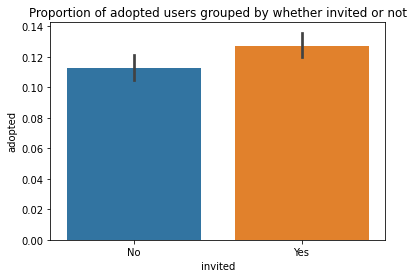

In [33]:
#1) Invited or not? 
_ = sns.barplot(x='invited',y='adopted', data=users)
_.set(xticklabels = ['No','Yes'])
plt.title('Proportion of adopted users grouped by whether invited or not')
plt.show()

Being invited by a user seem to lead to slightly higher adoption.

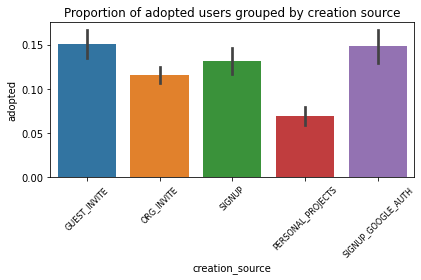

In [34]:
#2) Creation source
_ = sns.barplot(x='creation_source',y='adopted', data=users)
plt.title('Proportion of adopted users grouped by creation source')
plt.xticks(fontsize=8,rotation=45)
plt.tight_layout()
plt.savefig('source.png')
plt.show()

Creation source may have significant effects on user adoption: personal projects being lowest, while guest invite and google sign up being highest.

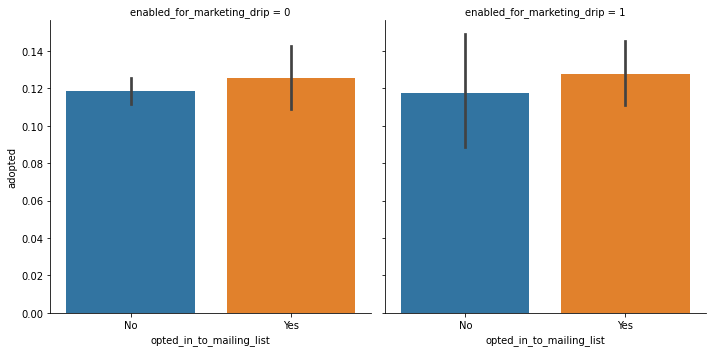

In [35]:
#3) Mailing list and/or marketing drip?
_ = sns.catplot(x='opted_in_to_mailing_list',y='adopted', col='enabled_for_marketing_drip',data=users, kind='bar')
_.set(xticklabels = ['No','Yes'])

plt.show()

Opt in mailing list or marketing drip do not seem to affect user adoption significantly

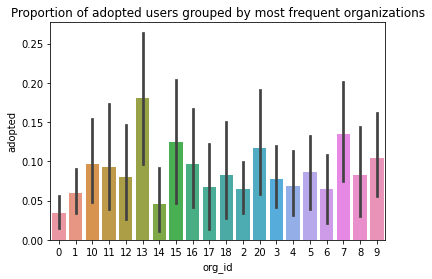

In [36]:
#4) Source organizations 
top_orgs = users.org_id.value_counts()[0:20].index
_ = sns.barplot(x='org_id',y= 'adopted',data=users[users.org_id.isin(top_orgs)])
plt.title('Proportion of adopted users grouped by most frequent organizations')
plt.show() 

Among users from most frequent organizations, there are higher adoption rate in users from a few of those.  
However, there are no "major players' in org ids like those in email domains. So we will not consider org ids in subsequent analysis

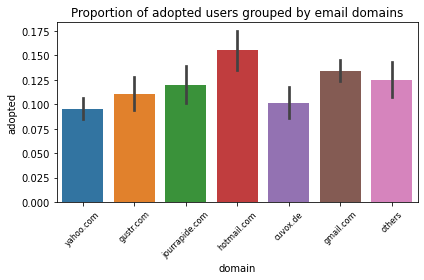

In [37]:
#5) Top email domains
_ = sns.barplot(x='domain',y='adopted', data=users)
plt.title('Proportion of adopted users grouped by email domains')
plt.xticks(fontsize=8,rotation=45)
plt.tight_layout()
plt.savefig('emaildomain.png')

plt.show()

Users signed up with hotmail and gmail have higher adoption.   

Next, we can engineer some numeric features potentially predictive of user adoption:   
1)number of sessions 30 days after sign up and 2) 30 days prior to last session

In [38]:
engage = engage.reset_index()

In [39]:
from collections import defaultdict
from datetime import timedelta

visits_first30days = defaultdict(list)
visits_last30days = defaultdict(list)

# Extract each user's sign up and visits' time
for user in engage.user_id.unique():
    creation_time = users[users.object_id==user].creation_time # A user's sign up time
    last_session = users[users.object_id==user].last_session_creation_time # A user's last session time
    time_visits = engage[engage.user_id == user].time_stamp # A user's all visits time
    
    # Count how many visits of a user happened within the first 30 days of sign up
    counts_first30days=0
    counts_last30days=0
    for i in time_visits.index:
        time_visit = time_visits[i] # get each time stamp which indexed from 1 
        if (time_visit < creation_time + timedelta(days=30)).values[0]:
            counts_first30days += 1
        elif (time_visit > last_session - timedelta(days=30)).values[0]:
            counts_last30days += 1
    visits_first30days[user].append(counts_first30days)
    visits_last30days[user].append(counts_last30days)

In [40]:
len(visits_last30days.keys())

8823

In [41]:
# Merge new features with users 
first30days = pd.DataFrame.from_dict(visits_first30days, orient= 'index')
last30days = pd.DataFrame.from_dict(visits_last30days, orient= 'index')
first30days.columns = ['visits_first30days']
last30days.columns = ['visits_last30days']
users2 = pd.concat([users.set_index('object_id'), first30days, last30days], axis=1)

In [42]:
users2.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,invited,domain,visits_first30days,visits_last30days
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,yahoo.com,1.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,gustr.com,3.0,3.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,gustr.com,1.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,yahoo.com,1.0,0.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,yahoo.com,1.0,0.0


In [43]:
# Remove missing values. Drop column invited_by_user_id since it is unlikely useful
users2 = users2.drop(columns=['invited_by_user_id']).dropna() # remove null values
users2.shape

(8823, 13)

In [44]:
# Remove outliers use winsorization
from scipy.stats.mstats import winsorize
users2['visits_first30days_win'] = winsorize(users2['visits_first30days'],limits=[0.05,0.05])
users2['visits_last30days_win'] = winsorize(users2['visits_last30days'],limits=[0.05,0.05])
users2.shape

(8823, 15)

In [45]:
users2.isnull().sum().sum()

0

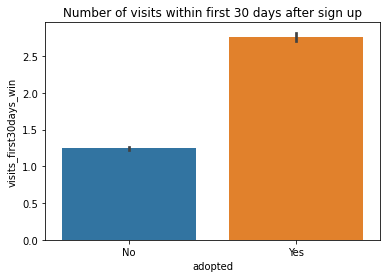

In [46]:
# 6) Being active first 30 days after sign-up and last 30 days before last session.
_ = sns.barplot(x='adopted', y='visits_first30days_win', data=users2)
_.set(xticklabels = ['No','Yes'])
plt.title('Number of visits within first 30 days after sign up')
plt.show()

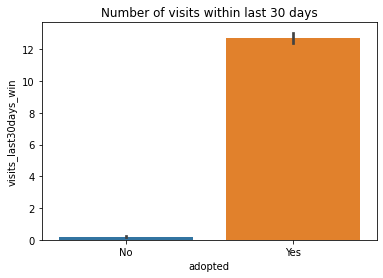

In [47]:
_ = sns.barplot(x='adopted', y='visits_last30days_win', data=users2)
_.set(xticklabels = ['No','Yes'])
plt.title('Number of visits within last 30 days')
plt.show()

# Logistic regression and random forest classifier 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Upsample data by adopted
users_adopted = resample(users2[users2.adopted==1],replace=True,n_samples=users2[users2.adopted==0].shape[0])

users_upsampled = pd.concat([users2[users2.adopted==0],users_adopted])

In [50]:
X = pd.get_dummies(users_upsampled[['creation_source','invited','domain','visits_first30days_win','visits_last30days_win']], columns=['creation_source','invited','domain'])
y = users_upsampled.adopted

In [51]:
X.shape

(14756, 16)

### Logsitic regression model

In [52]:
lm = LogisticRegression()

# Scale and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

xtrain,xtest,ytrain,ytest = train_test_split(X_scaled,y,test_size=0.3,random_state=5)


# GridsearchCV
Cs = [0.01, 0.1,0, 1,10]
model=GridSearchCV(lm, param_grid={'C':Cs}, scoring='roc_auc')
model.fit(xtrain,ytrain)
bestC= model.best_params_['C']

# Train with best C
lm_best = LogisticRegression(C=bestC)
lm_best.fit(xtrain,ytrain)

# Evaluate models
train_auroc = roc_auc_score(ytrain,lm_best.predict_proba(xtrain)[:,1])
test_auroc = roc_auc_score(ytest,lm_best.predict_proba(xtest)[:,1])

print('Best C:', bestC)
print('AUROC for training data:',train_auroc)
print('AUROC for testing data:',test_auroc)
print('Classification report for test data:\n',
        classification_report(lm_best.predict(xtest),ytest, 
        target_names=['Not adopted','Adopted']))

# Get coefficients
coefs = lm_best.coef_.flatten()
features = pd.DataFrame({'features': X.columns.tolist(), 'coefs':coefs}).sort_values(by=['coefs'],
                                                                                     ascending=False)
features = features.set_index('features')

Best C: 10
AUROC for training data: 0.9945588730194247
AUROC for testing data: 0.9940892772222868
Classification report for test data:
               precision    recall  f1-score   support

 Not adopted       0.97      0.95      0.96      2245
     Adopted       0.95      0.97      0.96      2182

    accuracy                           0.96      4427
   macro avg       0.96      0.96      0.96      4427
weighted avg       0.96      0.96      0.96      4427



In [53]:
features

,coefs
features,
visits_last30days_win,8.016102
visits_first30days_win,1.518463
domain_jourrapide.com,0.113091
creation_source_SIGNUP,0.098077
domain_gmail.com,0.087856
domain_cuvox.de,0.076749
creation_source_ORG_INVITE,0.030534
invited_0,0.010305
invited_1,-0.010305


### Random forest classifier

In [54]:
rf = RandomForestClassifier()

xtrain,xtest,ytrain,ytest = train_test_split(X.values,y,test_size=0.3,random_state=5)

# GridsearchCV
max_depth = [3,4,5]
min_samples_split = [200,400, 800]
min_samples_leaf = [10, 50 ,100]

params = {'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,}
model=GridSearchCV(rf, param_grid=params, scoring='roc_auc')
model.fit(xtrain,ytrain)
best_params= model.best_params_

In [55]:
# Train with best C
rf_best= RandomForestClassifier(max_depth = best_params['max_depth'],
                        min_samples_split = best_params['min_samples_split'],
                        min_samples_leaf = best_params['min_samples_leaf'])


rf_best.fit(xtrain,ytrain)
print('Best parameters:',best_params)

# Model evaluation
rf_train_auroc = roc_auc_score(ytrain,rf_best.predict_proba(xtrain)[:,1])
rf_test_auroc = roc_auc_score(ytest,rf_best.predict_proba(xtest)[:,1])
print('AUROC for training data:',rf_train_auroc)
print('AUROC for testing data:',rf_test_auroc)
print('Classification report for test data:\n',
      classification_report(rf_best.predict(xtest),ytest, 
                            target_names=['Not adopted','Adopted']))

# Get scaled coefficients which indicate the importance of features
importance = pd.DataFrame({'VarCode': X.columns, 
                           'Importance': rf_best.feature_importances_}).sort_values(by=['Importance'],
                                                                            ascending=False)
importance = importance.set_index('VarCode')


Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 200}
AUROC for training data: 0.9910050964215421
AUROC for testing data: 0.989136189502344
Classification report for test data:
               precision    recall  f1-score   support

 Not adopted       0.94      0.98      0.96      2121
     Adopted       0.98      0.94      0.96      2306

    accuracy                           0.96      4427
   macro avg       0.96      0.96      0.96      4427
weighted avg       0.96      0.96      0.96      4427



In [56]:
summary = pd.concat([features,importance], axis=1).reset_index()
summary.columns = ['Features','LogisticRegression_coefs','RandomForest_importance']
summary.sort_values(by='LogisticRegression_coefs', ascending=False)

,Features,LogisticRegression_coefs,RandomForest_importance
15,visits_last30days_win,8.016102,0.651307
14,visits_first30days_win,1.518463,0.341431
9,domain_jourrapide.com,0.113091,0.000423
3,creation_source_SIGNUP,0.098077,0.000471
6,domain_gmail.com,0.087856,0.000350
5,domain_cuvox.de,0.076749,0.000305
1,creation_source_ORG_INVITE,0.030534,0.000379
12,invited_0,0.010305,0.000273
13,invited_1,-0.010305,0.000334
7,domain_gustr.com,-0.019135,0.000420


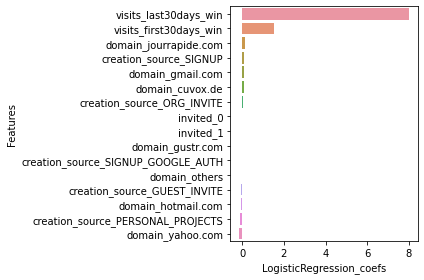

In [57]:
_=sns.barplot(x='LogisticRegression_coefs', y='Features', 
              data=summary.sort_values(by='LogisticRegression_coefs', ascending=False))
plt.tight_layout()
plt.savefig('feature_coefs.png')
plt.show()

In [58]:
# Combine accuracy scores into one dataframe
auroc = pd.DataFrame({'LogisticRegression': [train_auroc,test_auroc],
              'RandomForest':[rf_train_auroc, rf_test_auroc]}, index=['Training AUROC', 'Testing AUROC'])

In [59]:
auroc

,LogisticRegression,RandomForest
Training AUROC,0.994559,0.991005
Testing AUROC,0.994089,0.989136


Logistic regression and random forest models had similar results, by which the two numeric variables are most predictive: being active first 30 days after sign-up and last 30 days before last session. 